## Installation
[ref](https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynbhttps://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynbhttps://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynbhttps://github.com/qubvel-org/segmentation_models.pytorch/blob/main/examples/cars%20segmentation%20(camvid).ipynb)

In [107]:
# do it by using shell file pip install --user --proxy http://proxy:80 torchsummary kornia segmentation-models-pytorch albumentations wandb
# !pip install torchsummary
# !pip install kornia
# !pip install segmentation-models-pytorch
# !pip install albumentations
# !pip install wandb

In [108]:
!pwd

/home/hpc/rlvl/rlvl102h


## Configs

Unable to run wandb from HPC.

In [109]:
# import wandb
# start a new wandb run to track this script
import datetime
import os

CONFIGS={
    "loss":'multiclass',
    "project":"Orange Segmentation",
    "activation":"softmax2d",
    "name":f"focal_{datetime.datetime.now().date()}",
    "height" : 416 ,
    "train_size":0.8, #used for train/test split
    "epoch" : 100,
    "width" : 192,
    "encoder" : "resnet18",
    "batch_size" : 64,
     "learning_rate" : 0.00001,
    "shuffle_seed" : 100,
    "description":"Let's try this settings first.",
    'data_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/Orange_Image_Data/Orange_Image_Data',
    'labels_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/data/project-4-at-2024-03-02-15-13-497758b6.json',
    'train_dir':'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation//train_res',
    'model_path':  '/home/hpc/rlvl/rlvl102h/train_res/default_model.pth',#'/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation/train_res/Orange Segmentation/DiceLoss_2024-07-29/checkpoint_18.pth','/home/hpc/rlvl/rlvl102h/train_res/default_model.pth',
    'start_epoch':0
    
}
# os.environ["WANDB_MODE"] = "offline"

# wandb.init(project=CONFIGS['project'],config=CONFIGS,name=CONFIGS['name'])


## Only when on HPC

In [110]:
from pathlib import Path

train_dir = Path(CONFIGS['train_dir'])
project_dir=train_dir/Path(CONFIGS['project'])
run_dir = project_dir/Path(CONFIGS['name'])

if not train_dir.exists():
    train_dir.mkdir(parents=True)

if not project_dir.exists():
    project_dir.mkdir(parents=True)
    
if not run_dir.exists():
    run_dir.mkdir(parents=True)



## Imports

In [111]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

## DataSet Handler

In [112]:
class DataLabels:
    def __init__(self, root_dir, labels_file, shuffle_seed=42, split_ratio=0.8, max_samples=-1):
        """
        root_dir: From where all dataset is being read.
        labels_file: Labels file path.
        shuffle_seed: to handle random split.
        split_ratio: first half train, second will be test
        max_samples: max number of samples to take. -1 means all.
        """
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.images_dir = root_dir
        self.shuffle_seed = shuffle_seed
        self.split_ratio = split_ratio
        self.max_samples = max_samples
        
        self.labels, self.label_counts = self.load_labels(labels_file)
        np.random.seed(shuffle_seed)
        fnames = list(self.labels.keys())
        np.random.shuffle(fnames)
        self.idxs = list(range(len(fnames)))
        self.labels = {k: self.labels[k] for k in fnames}
        self.train_idx = self.idxs[:int(len(self.labels) * split_ratio)]
        self.valid_idx = self.idxs[len(self.train_idx):]
        self.train_labels = {fnames[k]: self.labels[fnames[k]] for k in self.train_idx}
        self.valid_labels = {fnames[k]: self.labels[fnames[k]] for k in self.valid_idx}

    def load_labels(self, labels_dir):
        # Load segmentation labels from JSON file
        with open(labels_dir, 'r') as f:
            segmentation_data = json.load(f)

        final_labels = {}
        label_counts = {}
        self.label_names = []
        img_cnts = 0

        

        for sm in segmentation_data:
            img_name = "IMG" + sm['image'].split('-IMG')[1]
            img_dict = {}

            if sm.get('label') is None:
                continue

            for labels in sm['label']:
                width = labels['original_width']
                height = labels['original_height']
                points = np.array(labels['points']).reshape(-1, 2)
                points[:, 0] = points[:, 0] * width / 100
                points[:, 1] = points[:, 1] * height / 100

                label_names = labels['polygonlabels']

                for label_name in label_names:
                    self.label_names.append(label_name)
                    if img_dict.get(label_name) is None:
                        img_dict[label_name] = []
                    img_dict[label_name].append(points)

            final_labels[img_name] = img_dict
            label_counts[img_name] = {k: len(v) for k, v in img_dict.items()}
            img_cnts += 1
            
            if img_cnts >= self.max_samples and self.max_samples > 0:
                break

        self.label_names = sorted(list(set(self.label_names)))
        return final_labels, label_counts

class DataSet(Dataset):
    def __init__(self, kind=1, data_labels=None, transform=None, 
                 color_space="RGB", multiclass=True):
        """
        kind: 1 for training and 0 for validation.
        data_labels: dictionary containing labels.
        transform: what transformation to apply.
        color_space: rgb/hsv or any other.
        multiclass: if True, target will be N,H,W else, N,C,H,W
        """
        self.data_labels = data_labels
        self.color_space=color_space
        self.transform = transform
        self.multiclass = multiclass
        # 1 for train, 0 for valid
        if kind == 1:
            self.curr_labels = self.data_labels.train_labels
        else:
            self.curr_labels = self.data_labels.valid_labels

    def __len__(self):
        return len(self.curr_labels)

    def __getitem__(self, idx):
        img_name = list(self.curr_labels.keys())[idx]
        img_path = os.path.join(self.data_labels.images_dir, img_name)

        # Load image
        image = Image.open(img_path).convert(self.color_space)
        image = np.array(image)

        # Create masks for each class label
        background = np.zeros(image.shape[:2], dtype=np.uint8) + 255
        healthy = np.zeros(image.shape[:2], dtype=np.uint8)
        infected = np.zeros(image.shape[:2], dtype=np.uint8)
        
        masks_dict = {"Background": background, "Healthy": healthy, "Infected": infected}
        
        for label_name, points_list in self.curr_labels[img_name].items():
            mask = masks_dict.get(label_name)

            # Draw each mask on the blank mask
            for points in points_list:
                points = np.round(points).astype(int)
                mask = cv2.fillPoly(mask, [points], 255)
                background = cv2.fillPoly(background, [points], 0)

            masks_dict[label_name] = mask
        background = background
        
        masks = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        masks[:, :, 0] = masks_dict["Background"]
        masks[:, :, 1] = masks_dict["Healthy"]
        masks[:, :, 2] = masks_dict["Infected"]

        if self.transform:
            augmented = self.transform(image=image, masks=masks)
            image = augmented['image']
            masks = augmented['masks']
        if self.multiclass:
            # for multiclass we need mask in format N, H, W. Each value in it represents class value.
            # class should start from 0.
            nmasks = np.zeros((masks.shape[0], masks.shape[1]))
            nmasks[masks[:, :, 1]>0] = 1
            nmasks[masks[:, :, 2]>0] = 2
            masks=torch.tensor(nmasks).long()
        return image.float(), masks

def get_train_transforms(height, width):
    return A.Compose([
        A.HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
        A.VerticalFlip(p=0.5),    # Apply vertical flip with 50% probability
        # A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.Resize(height, width),  # Resize image at the end
        ToTensorV2()
], additional_targets={'masks': 'mask'})

def get_test_transforms(height, width):
    return A.Compose([
        A.Resize(height, width),
        ToTensorV2()
    ], additional_targets={'masks': 'mask'})

# dataset and dataloader
data_labels = DataLabels(root_dir=CONFIGS['data_dir'], 
                         labels_file=CONFIGS['labels_dir'], 
                         split_ratio=CONFIGS['train_size'],
                        max_samples=-100,
                        shuffle_seed=CONFIGS['shuffle_seed'])

train_transform = get_train_transforms(height=CONFIGS['height'], width=CONFIGS['width'])
test_transform = get_test_transforms(height=CONFIGS['height'], width=CONFIGS['width'])

train_dataset = DataSet(kind=1, data_labels=data_labels, transform=train_transform)
test_dataset = DataSet(kind=0, data_labels=data_labels, transform=test_transform)



### Plot Sample Data

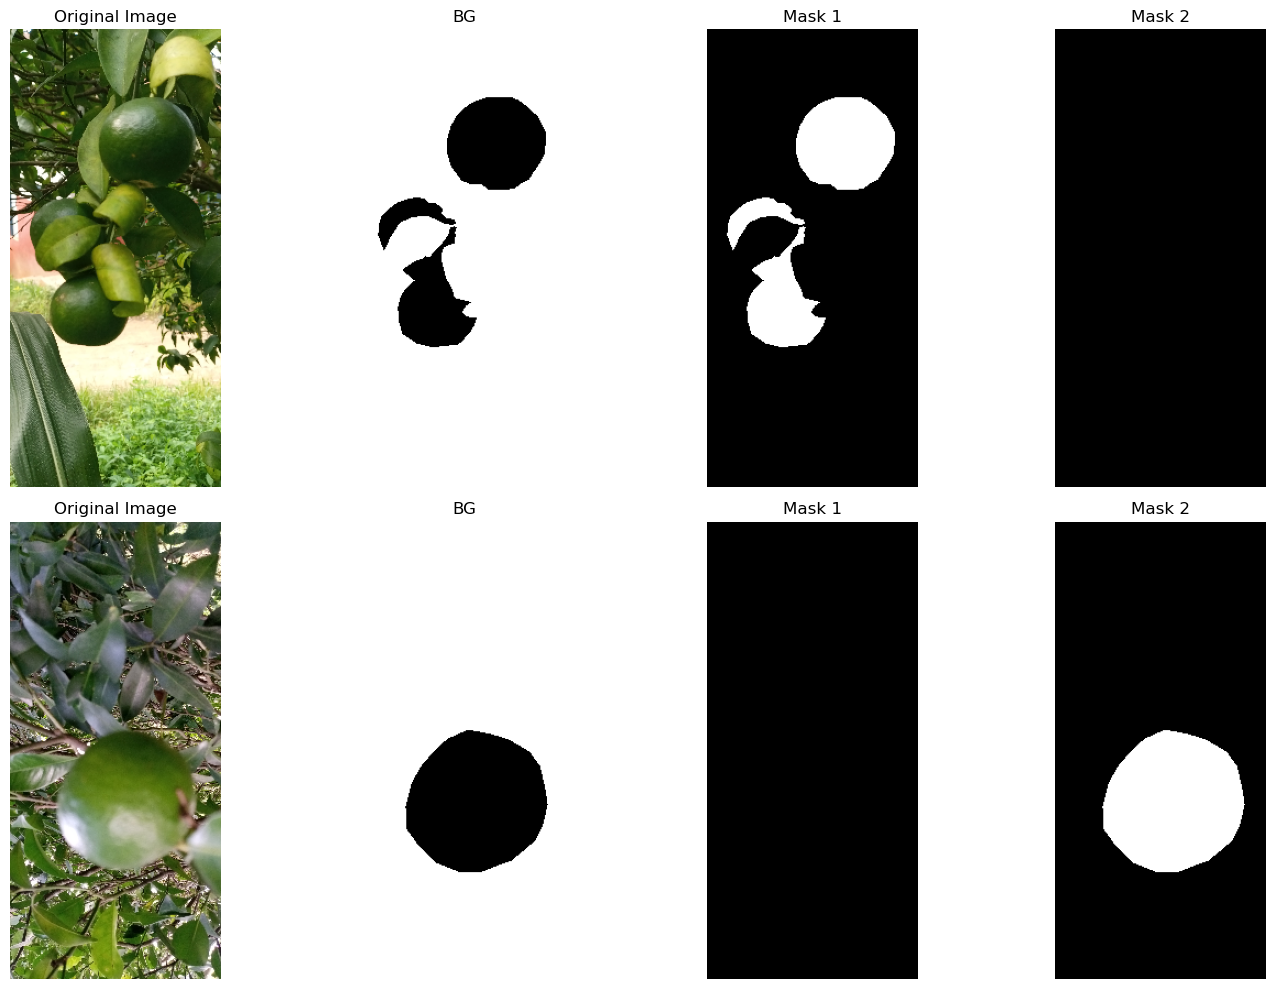

In [113]:
import matplotlib.pyplot as plt

# Define the number of examples to visualize
num_examples = 2

# Create a figure for plotting
fig, axs = plt.subplots(num_examples, 4, figsize=(15, num_examples * 5))

# Iterate through the dataset and display a few samples
for i in range(num_examples):
    # Get image and masks
    image, masks = train_dataset[i]

    # Convert tensor to numpy array and transpose dimensions
    image = image.permute(1, 2, 0).numpy().astype(np.uint8)
    masks = masks.numpy()  # Convert masks to shape (400, 180, 2)
#     print(masks)

    # Split masks
    mask0 = (masks==0).astype(int)*255
    mask1 = (masks==1).astype(int)*255
    mask2 = (masks==2).astype(int)*255
    
    # Plot image
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    # Plot first mask
    axs[i, 1].imshow(mask0, cmap='gray')
    axs[i, 1].set_title('BG')
    axs[i, 1].axis('off')

    # Plot second mask
    axs[i, 2].imshow(mask1, cmap='gray')
    axs[i, 2].set_title('Mask 1')
    axs[i, 2].axis('off')
    
    # Plot second mask
    axs[i, 3].imshow(mask2, cmap='gray')
    axs[i, 3].set_title('Mask 2')
    axs[i, 3].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


## Train/Test Loader

In [114]:
train_loader = DataLoader(train_dataset, batch_size=CONFIGS['batch_size'], shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=CONFIGS['batch_size'], shuffle=True, num_workers=4)

## Defining A Model

In [115]:
import os
# os.chdir('/home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation')

import torch 
import torchvision
import os

os.environ['TORCH_HOME'] = CONFIGS['train_dir']

!pwd

/home/hpc/rlvl/rlvl102h


In [120]:
# unable to download model so loading default unet 
model_path =CONFIGS['model_path']
if Path(model_path).exists():
    model = torch.load(model_path)
    print(f"Loaded {model_path}")

Loaded /home/hpc/rlvl/rlvl102h/train_res/default_model.pth


In [124]:
!export http_proxy=http://proxy:80
!export https_proxy=http://proxy:80

In [127]:
# import segmentation_models_pytorch as smp
# from torchsummary import summary

# DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
# ENCODER = CONFIGS["encoder"]
# ENCODER_WEIGHTS = 'train_res/resnet18-5c106cde.pth'
# CLASSES = 3 #bg, healthy, infected
# ACTIVATION = CONFIGS['activation'] 

# model = smp.Unet(
#     encoder_name=ENCODER,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     # encoder_weights=ENCODER_WEIGHTS,
#     in_channels=2,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=CLASSES,
#     activation = ACTIVATION
    
# ).to(DEVICE)
# print(f"Last layer's activation: {ACTIVATION}")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/hpc/rlvl/rlvl102h/Orange-Dataset-Segmentation//train_res/hub/checkpoints/resnet18-5c106cde.pth


URLError: <urlopen error [Errno 101] Network is unreachable>

## Loss and Optimizer


In [12]:
from segmentation_models_pytorch.utils.base import Metric
import segmentation_models_pytorch.utils.functional as smp_f
import torch.nn.functional as F
class IoU(Metric):
    __name__ = "iou_score"
    def __init__(
        self, eps=1e-7, threshold=0.5, ignore_channels=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):        
        one_hot_target = F.one_hot(y_gt, y_pr.size(1))  # Shape: (N, H, W, C)
        one_hot_target = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)       
        return smp_f.iou(
            y_pr,
            one_hot_target,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )
    
    def forward_each_class(self, y_pr, y_gt):
        one_hot_target = F.one_hot(y_gt, y_pr.size(1))  # Shape: (N, H, W, C)
        one_hot_target = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)
        
        ious=[]
        for c in range(one_hot_target.size(1)):
            ious.append(smp_f.iou(
                y_pr[:,c,:,:],
                one_hot_target[:,c,:,:],
                eps=self.eps,
                threshold=self.threshold,
                ignore_channels=self.ignore_channels,
            ))
        return torch.tensor(ious)

In [13]:
import segmentation_models_pytorch.utils as smp_utils
import segmentation_models_pytorch as smp

criterion = smp.losses.FocalLoss(mode='multiclass')
# criterion = smp.losses.DiceLoss(mode='multiclass')
criterion.__name__ = "DiceLoss"
metrics = [
    IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [14]:
torch.save(optimizer,'optim.pth')

In [15]:
torch.load('optim.pth')

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

### Test Loss and IoU

In [14]:
# inputs,targets = next(iter(test_loader))
# predictions=model(inputs.to(DEVICE)).cpu()
# inputs.shape,targets.shape,predictions.shape, predictions[:,1,:,:].shape

In [15]:
# criterion(predictions, targets), IoU().forward(predictions, targets),IoU().forward_each_class(predictions, targets)

In [16]:
# del predictions
# del inputs
# del targets

## Epoch Runners

In [17]:
 #create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Train

In [18]:
# /kaggle/working/best_model.pth

### View Performance

In [19]:
import json
def compare_results(dataset, model, epoch, device, num_examples=2):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(num_examples*2, 4, figsize=(12, num_examples * 4))
        fig.suptitle(f'Test Images and Predicted Masks - Epoch {epoch + 1}')

        for i in range(0, 
                       num_examples*2,2):
            images, masks = dataset[i]

            images = images.unsqueeze(0).to(device)
            masks = masks.unsqueeze(0).to(device)
            
            
            # Forward pass through the model
            outputs = model(images)
            one_hot_target = F.one_hot(masks, outputs.size(1))  # Shape: (N, H, W, C)
            masks = one_hot_target.permute(0, 3, 1, 2).contiguous()  # Shape: (N, C, H, W)

            # Convert tensors to numpy arrays for plotting
            image_np = images.squeeze(0).cpu().permute(1, 2, 0).detach().numpy()
            true_mask_np = masks.squeeze(0).cpu().detach().numpy()
            pred_mask_np = 255*(outputs.squeeze(0).cpu().numpy()>0.5)

            # Plot original image, true mask, and predicted mask in the first row
            axes[i, 0].imshow(image_np.astype(np.uint8))
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(true_mask_np[0], cmap='gray')  # Plotting the first mask
            axes[i, 1].set_title('BG')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(true_mask_np[1], cmap='gray')  # Plotting the first mask
            axes[i, 2].set_title('Healthy')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(true_mask_np[2], cmap='gray')  # Plotting the second mask
            axes[i, 3].set_title('Infected')
            axes[i, 3].axis('off')


            # Plot predicted mask in the second row
            axes[i+1, 0].imshow(image_np.astype(np.uint8))
            axes[i+1, 0].set_title('Original Image')
            axes[i+1, 0].axis('off')        
            axes[i + 1, 1].imshow(pred_mask_np[0], cmap='gray')  # Plotting the predicted mask
            axes[i + 1, 1].set_title('Predicted BG')
            axes[i + 1, 1].axis('off')
            axes[i + 1, 2].imshow(pred_mask_np[1], cmap='gray')  # Plotting the predicted mask
            axes[i + 1, 2].set_title('Predicted Healthy')
            axes[i + 1, 2].axis('off')
            axes[i + 1, 3].imshow(pred_mask_np[2], cmap='gray')  # Plotting the predicted mask
            axes[i + 1, 3].set_title('Predicted Infected')
            axes[i + 1, 3].axis('off')

        plt.tight_layout()
        plt.show()
    return fig

def val_iou_classwise(test_loader, device, model, iou_obj):
    model.eval()
    acc_ious = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model.to(device)(images)
            acc_ious+=iou_obj.forward_each_class(outputs, masks)
    acc_ious = acc_ious/len(test_loader)
    return [float(iou) for iou in acc_ious]

def write_checkpoint_logs(run_dir, start_epoch, current_epoch, logs, model):
    log_dir = run_dir/f'{start_epoch}_{current_epoch}_logs.json'
    # Write the dictionary to a JSON file
    with open(log_dir, 'w') as json_file:
        json.dump(logs, json_file, indent=4)
    
    
    if (run_dir/f'{start_epoch}_{current_epoch-1}_logs.json').exists() and current_epoch>(start_epoch+1):
        (run_dir/f'{start_epoch}_{current_epoch-1}_logs.json').unlink()
    
    model_dir = run_dir/f'checkpoint_{current_epoch}.pth'
    torch.save(model, str(model_dir))
    
    if (run_dir/f'checkpoint_{current_epoch-1}.pth').exists():
        (run_dir/f'checkpoint_{current_epoch-1}.pth').unlink()

def log_best(run_dir, start_epoch, current_epoch, model):
    torch.save(model, str(run_dir/f'{start_epoch}_{current_epoch}_best_model.pth'))
    
    if (run_dir/f'{start_epoch}_{current_epoch-1}_best_model.pth').exists() and     current_epoch>(start_epoch+1):
        (run_dir/f'{start_epoch}_{current_epoch-1}_best_model.pth').unlink()
    
    
    


Epoch: 0
valid: 100%|██████████| 19/19 [01:17<00:00,  4.07s/it, DiceLoss - 0.6109, iou_score - 0.428] 
Valid IoUs [BG, Healthy, Infected]: (0.4338947534561157, 0.40417295694351196, 0.4109988212585449)


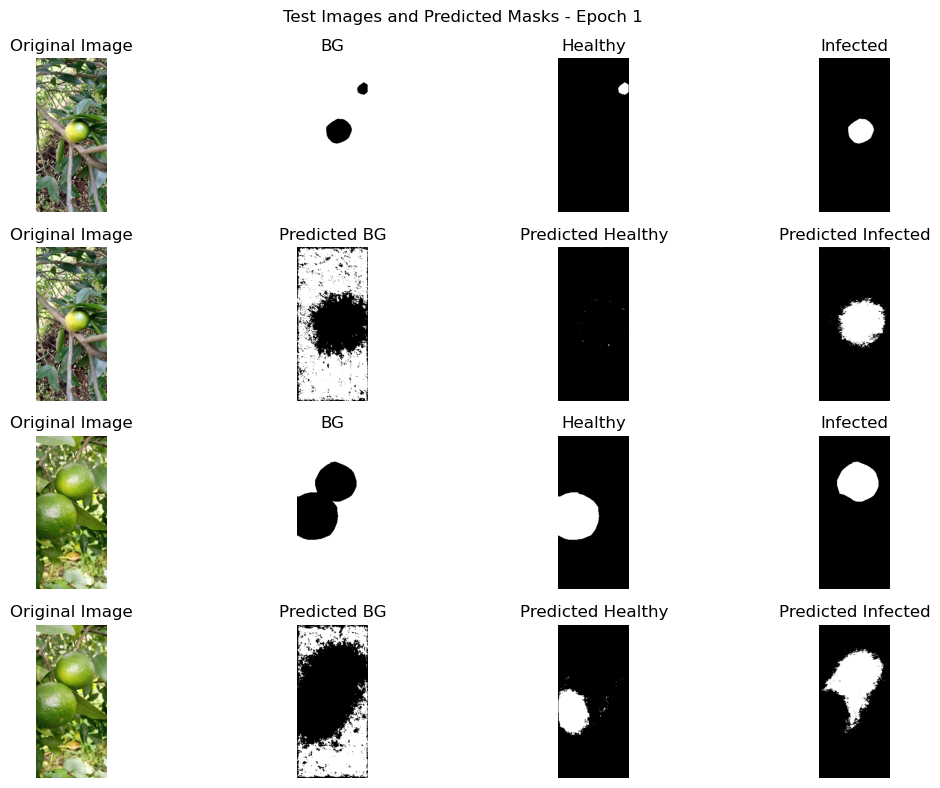

Model saved!

Epoch: 1
valid: 100%|██████████| 19/19 [01:07<00:00,  3.53s/it, DiceLoss - 0.5739, iou_score - 0.6047]
Valid IoUs [BG, Healthy, Infected]: (0.6285582780838013, 0.5267072916030884, 0.4996494948863983)
Model saved!

Epoch: 2
valid: 100%|██████████| 19/19 [01:06<00:00,  3.52s/it, DiceLoss - 0.5433, iou_score - 0.6579]
Valid IoUs [BG, Healthy, Infected]: (0.674950897693634, 0.5899379849433899, 0.5861431956291199)
Model saved!

Epoch: 3
valid: 100%|██████████| 19/19 [01:06<00:00,  3.52s/it, DiceLoss - 0.5192, iou_score - 0.7035]
Valid IoUs [BG, Healthy, Infected]: (0.7212709784507751, 0.6130983233451843, 0.638979434967041)
Model saved!

Epoch: 4
valid: 100%|██████████| 19/19 [01:07<00:00,  3.54s/it, DiceLoss - 0.503, iou_score - 0.7477] 
Valid IoUs [BG, Healthy, Infected]: (0.7722507119178772, 0.6353535652160645, 0.6317203044891357)
Model saved!

Epoch: 5
valid: 100%|██████████| 19/19 [01:06<00:00,  3.50s/it, DiceLoss - 0.4859, iou_score - 0.8069]
Valid IoUs [BG, Healthy, Infe

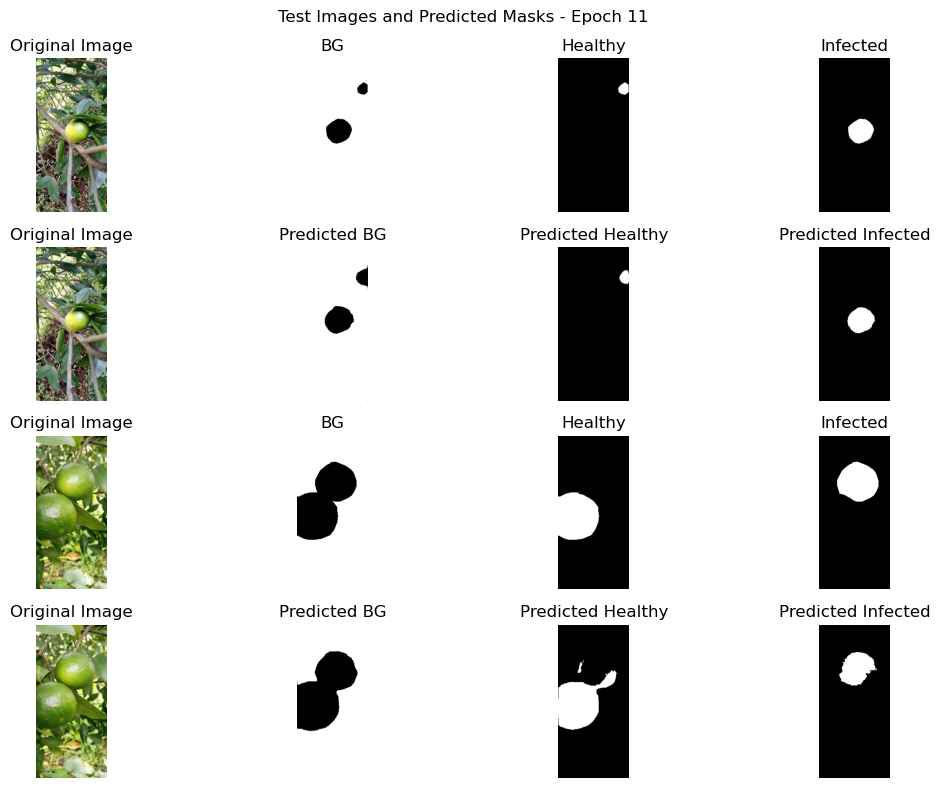

Model saved!

Epoch: 11
valid: 100%|██████████| 19/19 [01:05<00:00,  3.45s/it, DiceLoss - 0.4469, iou_score - 0.9231]
Valid IoUs [BG, Healthy, Infected]: (0.9620669484138489, 0.7191175818443298, 0.7510020732879639)
Model saved!

Epoch: 12
valid: 100%|██████████| 19/19 [01:04<00:00,  3.40s/it, DiceLoss - 0.4438, iou_score - 0.9183]
Valid IoUs [BG, Healthy, Infected]: (0.9601147174835205, 0.7091027498245239, 0.7394899129867554)

Epoch: 13
valid: 100%|██████████| 19/19 [01:05<00:00,  3.45s/it, DiceLoss - 0.4403, iou_score - 0.9219]
Valid IoUs [BG, Healthy, Infected]: (0.9672301411628723, 0.6868097186088562, 0.7313019037246704)

Epoch: 14
valid: 100%|██████████| 19/19 [01:05<00:00,  3.46s/it, DiceLoss - 0.4347, iou_score - 0.9302]
Valid IoUs [BG, Healthy, Infected]: (0.9688392281532288, 0.7330043911933899, 0.7599495053291321)
Model saved!

Epoch: 15
valid: 100%|██████████| 19/19 [01:05<00:00,  3.43s/it, DiceLoss - 0.4333, iou_score - 0.9229]
Valid IoUs [BG, Healthy, Infected]: (0.964820981

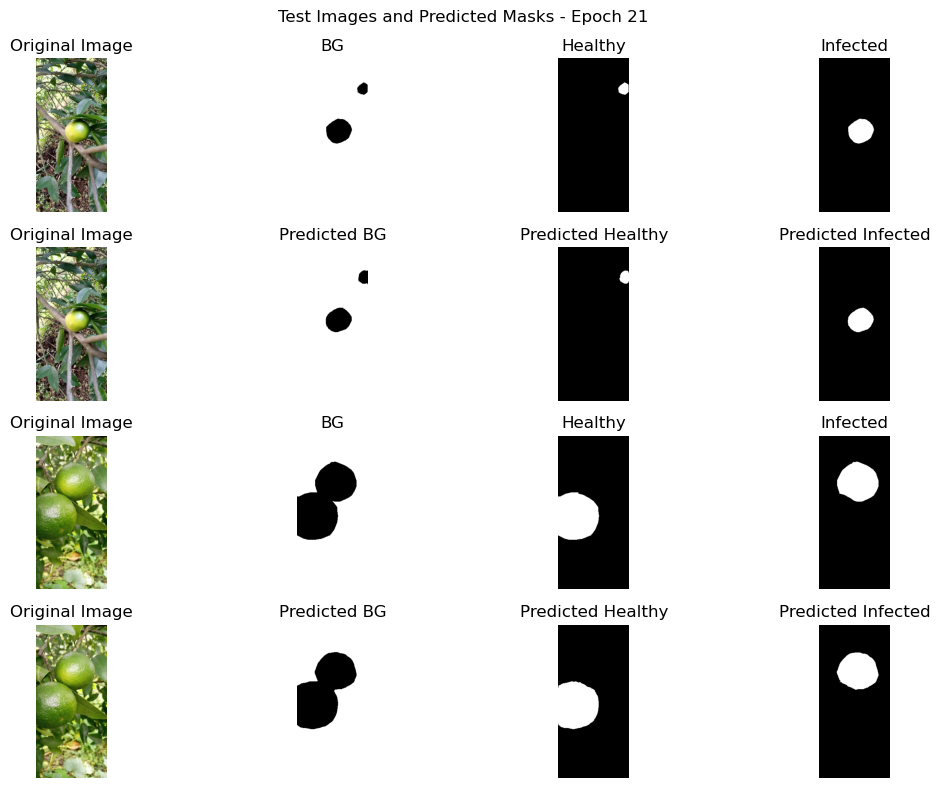

Model saved!

Epoch: 21
valid: 100%|██████████| 19/19 [01:17<00:00,  4.09s/it, DiceLoss - 0.4068, iou_score - 0.9446]
Valid IoUs [BG, Healthy, Infected]: (0.9763959646224976, 0.7782666683197021, 0.8025762438774109)
Model saved!

Epoch: 22
valid: 100%|██████████| 19/19 [01:17<00:00,  4.10s/it, DiceLoss - 0.4051, iou_score - 0.9433]
Valid IoUs [BG, Healthy, Infected]: (0.9760624766349792, 0.7731297016143799, 0.7998790740966797)

Epoch: 23
valid: 100%|██████████| 19/19 [01:17<00:00,  4.09s/it, DiceLoss - 0.4053, iou_score - 0.9398]
Valid IoUs [BG, Healthy, Infected]: (0.9744346737861633, 0.7650943398475647, 0.7913462519645691)

Epoch: 24
valid: 100%|██████████| 19/19 [01:17<00:00,  4.09s/it, DiceLoss - 0.4021, iou_score - 0.9468]
Valid IoUs [BG, Healthy, Infected]: (0.9766170382499695, 0.7895181179046631, 0.812098503112793)
Model saved!

Epoch: 25
valid: 100%|██████████| 19/19 [01:18<00:00,  4.12s/it, DiceLoss - 0.4007, iou_score - 0.9465]
Valid IoUs [BG, Healthy, Infected]: (0.9769634604

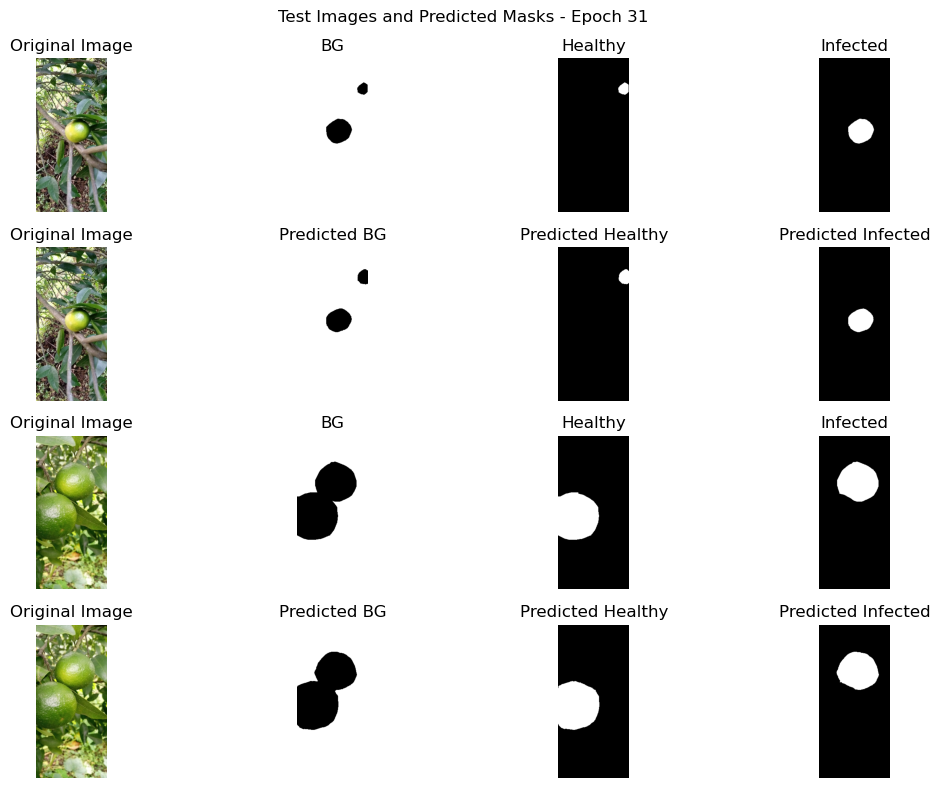

Model saved!

Epoch: 31
valid:   0%|          | 0/19 [00:00<?, ?it/s]Valid IoUs [BG, Healthy, Infected]: (0.9785546660423279, 0.8048068881034851, 0.8242577910423279)

Epoch: 32
train:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
max_score = 0
show_prediction_every=10
all_logs = {}
for i in range(0, CONFIGS['epoch']):
    i+=CONFIGS['start_epoch']
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(test_loader)
    valid_logs['bg_iou'], valid_logs['healthy_iou'], valid_logs['infected_iou']=val_iou_classwise(test_loader, DEVICE, model, metrics[0])
    wb_logs = {f'valid_{key}':value for key,value in valid_logs.items()}
    wb_logs.update({f'train_{key}':value for key,value in train_logs.items()})
    # wandb.log(wb_logs)
    all_logs[i]=wb_logs
    print(f"Valid IoUs [BG, Healthy, Infected]: {(valid_logs['bg_iou'], valid_logs['healthy_iou'], valid_logs['infected_iou'])}")
    
    if i%show_prediction_every==0:
        compare_results(test_dataset, model, i, DEVICE)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        log_best(run_dir,CONFIGS['start_epoch'], i, model)
        print('Model saved!')
    
    write_checkpoint_logs(run_dir, CONFIGS['start_epoch'], i, all_logs, model)

print("Training finished.")
# wandb.finish()